# Pre-processing the NICT JLE dataset

#### TODO: explanation : regular expressions - used pattern for tags

In [ ]:
import re
from os import listdir

# This function allows you to retrieve all the lines that are between the "B" tag and remove the new line
def generateCleanFile(filename):
    input = open("NICT_JLE_4.1/LearnerOriginal/" + filename, "r", encoding="latin1") 
    output = open("preProcessedData/" + filename, "w", encoding="latin1")
    lines = input.readlines()
    for line in lines:
        if '<B>' in line :
            output.write(line[3:len(line)-5])
            #output.write(line[3:len(line)-5])
    input.close()
    output.close() 

# This function allows each line of each file to delete all tags and their data
def generateCleanline(filename):
    input = open("preProcessedData/" + filename, "r", encoding="latin1")
    output = open("preProcessedDataLine/" + filename, "w", encoding="latin1")
    lines = input.readlines()
    for line in lines:
            content = removeAllInternalTags(line)
            output.write(content.lower())
    input.close()
    output.close() 


def removeAllInternalTags(line):
    pile = list()
    pile = [(m.start(0), m.end(0)) for m in re.finditer(r'<(.*?)>', line)]

    buffer = []
    counter = 0
    while len(pile) != 0:
        if line[pile[counter][0]+1] == '/':
            line = line[0:buffer[-1][0]] + line[pile[counter][1]:]
            pile = [(m.start(0), m.end(0)) for m in re.finditer(r'<(.*?)>', line)]
            counter = 0
            buffer.pop()
        else :
            buffer.append(pile[counter])
            counter+=1
    return line

# Keep only signaficant tags that will help with the prediction of the SST level of each participant 
# tags is the list of tags that the user wants to remove from the transcript 
def removeInternalTags(line, tags=[]):
    for tag in tags:
        doubleTagPattern = "<",tag,">(.+?)</",tag,">"
        singleTagPattern = "</?",tag,"*?>"
        line = re.sub(doubleTagPattern, "", line)
        line = re.sub(singleTagPattern, "", line)
    return re.sub(r"\s+", " ", line)


files = [f for f in listdir("NICT_JLE_4.1/LearnerOriginal")]

for f in files:
    generateCleanFile(f)
    
for f in files:
    generateCleanline(f)


# Processing the dataset: Bag of Words

explanation : BoW algo - stopwords


A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

    A vocabulary of known words.
    A measure of the presence of known words.

It is called a bag-of-words , because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. The complexity comes both in deciding how to design the vocabulary of known words (or tokens) and how to score the presence of known words.

#### Associate text file and score

In [2]:
from os import listdir

def extractScore(filename):
    score = {}
    input = open("NICT_JLE_4.1/LearnerOriginal/" + filename, "r", encoding="latin1") 
    lines = input.readlines()
    for line in lines:
        if '<SST_level>' in line :
            score = line[11]
            break
    input.close()
    return score

files = [f for f in listdir("NICT_JLE_4.1/LearnerOriginal")]

textScoreList = dict()

for f in files:
    textScoreList[f] = extractScore(f)

#### Create vocabulary 

As a first step, we create the function for generating the vocabulary 

In [3]:
from nltk.corpus import stopwords
from os import listdir
import numpy
import re
from sklearn.feature_extraction.text import CountVectorizer

def createVectorizer(text):
    vectorizer = CountVectorizer()
    vectorizer.fit(text)
    return vectorizer

def word_extraction(sentence):    
    ignore = set(stopwords.words('english')) 
    words = sentence.split()
    cleaned_text = [w.lower() for w in words if w not in ignore] 
    clean = ' '.join(cleaned_text)
    clean = re.sub(r"""
            [,.;@#?!&$]+ 
            \ *           
            """,
            " ",          
            clean, flags=re.VERBOSE)
    return clean
    

#### Dividing database to training and testing sets randomly 

In [18]:
from random import shuffle
from math import floor
import os

allFiles = os.listdir("preProcessedDataLine/")

# Randomize training data
shuffle(allFiles)

split = 0.7

split_index = floor(len(allFiles) * split)
trainingFiles = allFiles[:split_index]
testingFiles = allFiles[split_index:]


#### Creating vocab from training dataset

In [19]:
trainingText = list()
testingText = list()

for trainingFile in trainingFiles:
    trainingFileText = open("preProcessedDataLine/" + trainingFile, "r", encoding="latin1")
    l = trainingFileText.readline()
    trainingText.append(word_extraction(l))
    trainingFileText.close()

for testingFile in testingFiles:
    testingFileText = open("preProcessedDataLine/" + testingFile, "r", encoding="latin1")
    l = testingFileText.readline()
    testingText.append(word_extraction(l))
    testingFileText.close()

vectorizer = createVectorizer(trainingText)

trainingVector = vectorizer.transform(trainingText) 
testingVector = vectorizer.transform(testingText) 

trainingData = trainingVector.toarray() 
testingData = testingVector.toarray()

#### Generate BoW vectors for training data 

In [20]:
import pandas as pd


# dataframe for training data : inputs
x_train = pd.DataFrame(trainingData, columns = sorted(vectorizer.vocabulary_))
x_train.index = trainingFiles

# dataframe for training data : scores
y_train = pd.DataFrame([textScoreList[trainingFile] for trainingFile in trainingFiles], columns = ["score"])
y_train.index = trainingFiles


# dataframe for testing data : inputs
x_test = pd.DataFrame(testingData, columns = sorted(vectorizer.vocabulary_))
x_test.index = testingFiles

# dataframe for testing data : scores
y_test = pd.DataFrame([textScoreList[testingFile] for testingFile in testingFiles], columns = ["score"])
y_test.index = testingFiles

# remove columns that have more that 70% of values equal to zero
#x_train = x_train.loc[:, (x_train==0).mean() < .7]
#x_test = x_test[x_train.columns]


# Training the classifier to Predict SST

#### Classifiers and their corresponding accuracy and confusion matrix

In [21]:
print("Vocabulary size",len(sorted(vectorizer.vocabulary_)))
print("Training data size",x_train.shape)
print("testing data size",x_test.shape)

Vocabulary size 10636
Training data size (896, 10636)
testing data size (385, 10636)


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def conf_matrix(name,y_test,y_pred):
    cm_y1 = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10,7))
    sn.set(font_scale=2) # for label size
    sn.heatmap(cm_y1, annot=True, annot_kws={"size": 12}) # font size
    plt.title(name)
    plt.show()

Naive Bayes Accuracy: 0.509090909090909


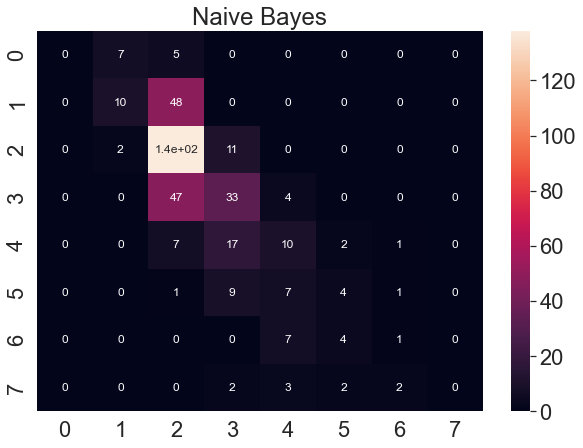

Logistic regression Accuracy: 0.509090909090909


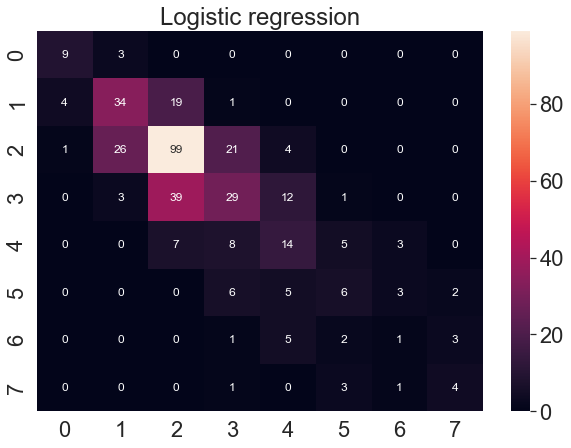

SVC Accuracy: 0.509090909090909


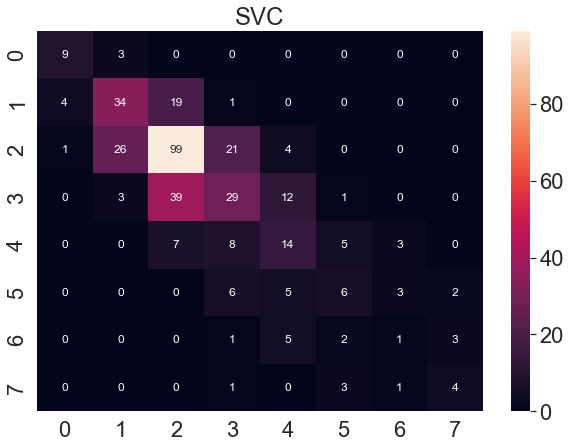

C:\Users\naifa\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy: 0.5246753246753246


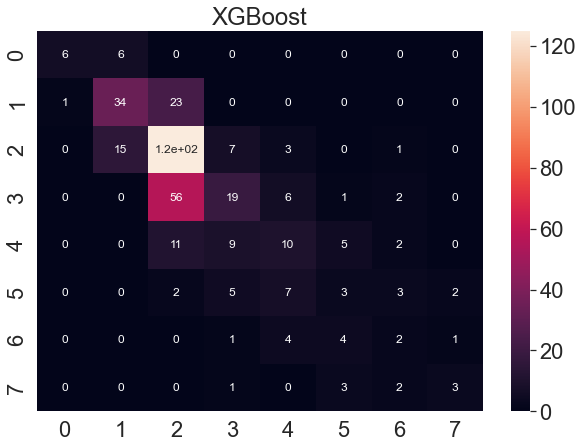

In [23]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics


#Naive Bayes Model
nb = MultiOutputClassifier(MultinomialNB()).fit(x_train, y_train)
y_pred = nb.predict(x_test)
print("Naive Bayes Accuracy:",metrics.accuracy_score(y_test, y_pred))
conf_matrix("Naive Bayes", y_test, y_pred)

#Logistic Regression Model (As we have unbalanced dataset, we use class_weight which will use inverse of counts of that class. It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1)
lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)) \
                    .fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("Logistic regression Accuracy:",metrics.accuracy_score(y_test, y_pred))
conf_matrix("Logistic regression", y_test, y_pred)

# SVC
svc = SVC(gamma="scale")
model = MultiOutputClassifier(estimator=svc)
model.fit(x_train, y_train)

y_pred = lr.predict(x_test)
print("SVC Accuracy:",metrics.accuracy_score(y_test, y_pred))
conf_matrix("SVC", y_test, y_pred)

# XGBoost
classifier = MultiOutputClassifier(XGBClassifier())
clf = Pipeline([('classify', classifier)])
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print("XGBoost Accuracy:",metrics.accuracy_score(y_test, y_pred))
conf_matrix("XGBoost", y_test, y_pred)

## Neural Network with Keras 

In [31]:
from keras import models
from keras import layers
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(len(x_train.columns),)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

train_labels = tf.one_hot(y_train['score'], depth=9)
test_labels = tf.one_hot(y_test['score'], depth=9)

X_train = x_train.to_numpy()
X_test = x_test.to_numpy()

history = model.fit(X_train, train_labels, epochs=40)
model.evaluate(X_test,  test_labels, verbose=2)

predictions = model.predict(X_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                340384    
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 9)                 153       
                                                                 
Total params: 341,065
Trainable params: 341,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
28/28 [==============================] - 1s 8ms/step - loss: 1.9118 - accuracy: 0.1373
Epoch 2/40
28/28 [==============================] - 0s 9ms/step - loss: 1.5201 - accuracy: 0.4799
Epoch 3/40
28/28 [==============================] - 0s 10ms/step - loss: 1.1534 - accuracy: 0.6127
Epoch 4/40
28/28 

# Alternative Data processing 

### word2vec

Since word2vec training is unsupervised, we can use the entirety of the dataset to train the word2vec model.

In [62]:
from gensim.models import Word2Vec


files = [f for f in listdir("preProcessedDataLine/")]
full_list = list()

for f in files:
    input = open("preProcessedDataLine/" + f, "r", encoding="latin1")
    full_list.append(word_extraction(input.readline()).split())

word2vec = Word2Vec(full_list, seed=1,
                    vector_size =300,
                    min_count=50,
                    window=30)
# summarize the loaded model
print(word2vec)
# summarize vocabulary
words = list(word2vec.wv.index_to_key)


Word2Vec(vocab=1198, vector_size=300, alpha=0.025)


In [63]:
import nltk 
import numpy as np
nltk.download('punkt')

class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(list(word2vec.wv.index_to_key))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naifa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import scikitplot.plotters as skplt
from sklearn.ensemble import RandomForestClassifier

def evaluate_features(X, y, clf=None):
    if clf is None:
        clf = LogisticRegression(class_weight='balanced', max_iter=3000)
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

In [69]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)

trainingText = list()
testingText = list()

for trainingFile in trainingFiles:
    trainingFileText = open("preProcessedDataLine/" + trainingFile, "r", encoding="latin1")
    l = trainingFileText.readline()
    trainingText.append(word_extraction(l))
    trainingFileText.close()

for testingFile in testingFiles:
    testingFileText = open("preProcessedDataLine/" + testingFile, "r", encoding="latin1")
    l = testingFileText.readline()
    testingText.append(word_extraction(l))
    testingFileText.close()

X_train = mean_embedding_vectorizer.fit_transform(trainingText)
X_test = mean_embedding_vectorizer.fit_transform(testingText)

y_train = pd.DataFrame([textScoreList[trainingFile] for trainingFile in trainingFiles], columns = ["score"])

evaluate_features(X_train, y_train["score"])
evaluate_features(X_train, y_train["score"],
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))
evaluate_features(X_train, y_train["score"],
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )                  

C:\Users\naifa\AppData\Local\Temp/ipykernel_18836/2256991548.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(transformed_X)
C:\Users\naifa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
C:\Users\naifa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  wa

Log loss: 1.302156676353831
Accuracy: 0.42857142857142855


C:\Users\naifa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished
C:\Users\naifa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.2045335274730296
Accuracy: 0.46986607142857145


C:\Users\naifa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [200]:
# dataframe for training data : scores
y_train.index = trainingFiles

# dataframe for testing data : scores
y_test = pd.DataFrame([textScoreList[testingFile] for testingFile in testingFiles], columns = ["score"])
y_test.index = testingFiles